# Clickbait Challenge at SemEval 2023 - Clickbait Spoiling

Task 1 on Spoiler Type Classification: The input is the clickbait post and the linked document. The task is to classify the spoiler type that the clickbait post warrants (either "phrase", "passage", "multi"). For each input, an output like ```{"uuid": "<UUID>", "spoilerType": "<SPOILER-TYPE>"}``` has to be generated where <SPOILER-TYPE> is either phrase, passage, or multi.
    
For each entry in the training and validation dataset, the following fields are available:

* uuid: The uuid of the dataset entry.
* postText: The text of the clickbait post which is to be spoiled.
* **targetParagraphs**: The main content of the linked web page to classify the spoiler type ***(task 1)*** and to generate the spoiler (task 2). Consists of the paragraphs of manually extracted main content.
* **targetTitle**: The title of the linked web page to classify the spoiler type ***(task 1)*** and to generate the spoiler (task 2).
* targetUrl: The URL of the linked web page.
* humanSpoiler: The human generated spoiler (abstractive) for the clickbait post from the linked web page. This field is only available in the training and validation dataset (not during test).
* spoiler: The human extracted spoiler for the clickbait post from the linked web page. This field is only available in the training and validation dataset (not during test).
* spoilerPositions: The position of the human extracted spoiler for the clickbait post from the linked web page. This field is only available in the training and validation dataset (not during test).
* **tags**: The spoiler type (might be "phrase", "passage", or "multi") that is to be classified in ***task 1*** (spoiler type classification). For task 1, this field is only available in the training and validation dataset (not during test). For task 2, this field is always available and can be used.

Some fields contain additional metainformation about the entry but are unused: postId, postPlatform, targetDescription, targetKeywords, targetMedia.

### Imports

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Preprocessing
import re
import string
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\xmart\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\xmart\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn import preprocessing

In [4]:
# Metrics
from sklearn import metrics

In [5]:
# Classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

### Read data

In [6]:
def create_df_from_jsonl(path, binary=False):
    df = pd.read_json(path, lines=True)
    df['document'] = df['postText'].apply(', '.join)
    df['tags'] = df['tags'].apply(', '.join)
    if binary:
        df = df[(df['tags'] == 'passage') | (df['tags'] == 'phrase')]
        df.reset_index(inplace=True)
    return df[['document', 'tags']]

In [7]:
train_df = create_df_from_jsonl('data/train.jsonl')
train_df.head(3)

,document,tags
0,"Wes Welker Wanted Dinner With Tom Brady, But Patriots QB Had Better Idea",passage
1,NASA sets date for full recovery of ozone hole,phrase
2,This is what makes employees happy -- and it's not their paycheck,phrase


In [8]:
validation_df = create_df_from_jsonl('data/validation.jsonl')
validation_df.head(3)

,document,tags
0,Five Nights at Freddy’s Sequel Delayed for Weird Reason,passage
1,Why Arizona Sheriff Joe Arpaio’s fate could hang on a single word,multi
2,Here’s how much you should be tipping your hairdresser,phrase


In [9]:
TRAIN_DF_COUNT = train_df.shape[0]
VAL_DF_COUNT = validation_df.shape[0]

print(f'Rows in train set: {TRAIN_DF_COUNT} \nRows in validation set: {VAL_DF_COUNT}')

Rows in train set: 3200 
Rows in validation set: 800


In [10]:
train_df['tags'].value_counts()

phrase     1367
passage    1274
multi       559
Name: tags, dtype: int64

In [11]:
validation_df['tags'].value_counts()

phrase     335
passage    322
multi      143
Name: tags, dtype: int64

### Encoding Labels

In [ ]:
tags_map = {'phrase': 0, 'passage': 1, 'multi': 2}
train_df['tags'] = train_df['tags'].map(tags_map)
validation_df['tags'] = validation_df['tags'].map(tags_map)

In [13]:
train_df.head(3)

,document,tags
0,"Wes Welker Wanted Dinner With Tom Brady, But Patriots QB Had Better Idea",1
1,NASA sets date for full recovery of ozone hole,0
2,This is what makes employees happy -- and it's not their paycheck,0


In [14]:
validation_df.head(3)

,document,tags
0,Five Nights at Freddy’s Sequel Delayed for Weird Reason,1
1,Why Arizona Sheriff Joe Arpaio’s fate could hang on a single word,2
2,Here’s how much you should be tipping your hairdresser,0


### Clear data

In [15]:
def clear_document(text):

    final_string = ""
    text = text.lower()
    
    # Remove punctuation and numbers
    text = re.sub(r'[^a-zA-Z ]+', '', text)

    # Remove stopwords
    text = text.split()
    
    stop_words = ["'s", "could", "might", "would", "sha", "ha", "n't", "'ve", "'d", "'ll", "'re", '’', "..."] \
              + nltk.corpus.stopwords.words("english")
    
    stop_words = set(stop_words) - {"why", "how", "where", "not", "this", "they", "who", "he", "she", "these",
                              "here", "there", "when", "that", "?"}

    text_filtered = [word for word in text if not word in stop_words]

    # Lemmatize
    lem = WordNetLemmatizer()
    final_string = ' '.join([lem.lemmatize(y) for y in text_filtered])

    return final_string

In [16]:
def clear_dataframe(df, target_col):
    df_cleaned = df
    df_cleaned[target_col] = df[target_col].apply(lambda x: clear_document(x))
    return df_cleaned

In [17]:
train_df = clear_dataframe(train_df, 'document')
train_df.head(3)

,document,tags
0,wes welker wanted dinner tom brady patriot qb better idea,1
1,nasa set date full recovery ozone hole,0
2,this make employee happy not paycheck,0


In [18]:
validation_df = clear_dataframe(validation_df, 'document')
validation_df.head(3)

,document,tags
0,five night freddys sequel delayed weird reason,1
1,why arizona sheriff joe arpaios fate hang single word,2
2,here how much tipping hairdresser,0


### TF-IDF

#### Create bag of words

In [19]:
count_vectorizer = CountVectorizer()
all_docs = (pd.concat([train_df, validation_df])['document'])
bow = count_vectorizer.fit_transform(all_docs)
bow.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [20]:
tfidf = TfidfTransformer()
tfidf_array = tfidf.fit_transform(count_vectorizer.fit_transform(all_docs)).toarray()
tfidf_array

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [21]:
train_df['document'] = pd.Series(list(tfidf_array[:TRAIN_DF_COUNT]))
validation_df['document'] = pd.Series(list(tfidf_array[TRAIN_DF_COUNT:]))

In [22]:
train_df.head(3)

,document,tags
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...]",1
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...]",0
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...]",0


In [23]:
validation_df.head(3)

,document,tags
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...]",1
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...]",2
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...]",0


### Encode labels

In [24]:
'''
label_enc = preprocessing.LabelEncoder()
label_enc.fit(pd.concat([train_df, validation_df])['tags'])
train_df['tags'] = label_enc.transform(train_df['tags'])
validation_df['tags'] = label_enc.transform(validation_df['tags'])
'''

"\nlabel_enc = preprocessing.LabelEncoder()\nlabel_enc.fit(pd.concat([train_df, validation_df])['tags'])\ntrain_df['tags'] = label_enc.transform(train_df['tags'])\nvalidation_df['tags'] = label_enc.transform(validation_df['tags'])\n"

### Train and test sets

In [25]:
X_train = [list(x) for x in train_df['document']]
y_train = train_df['tags']

In [26]:
X_test = [list(x) for x in validation_df['document']]
y_test = validation_df['tags']

### Predict labels

#### Prediction and metrics functions

In [27]:
def prediction(X_test, model_object):
    y_pred = model_object.predict(X_test)
    return y_pred
    
def cal_accuracy(y_test, y_pred):
    return metrics.accuracy_score(y_test,y_pred) * 100
    
def cal_f1(y_test, y_pred):
    return metrics.f1_score(y_test,y_pred, average=None) * 100
    
def cal_f1_weighted(y_test, y_pred):
    return metrics.f1_score(y_test,y_pred, average='weighted') * 100
    
def conf_matrix(y_test, y_pred):
    categories = ['phrase', 'passage', 'multi']
    cf_matrix = metrics.confusion_matrix(y_test, y_pred)
    sns.heatmap(cf_matrix, annot=True, xticklabels=categories, yticklabels=categories, fmt='3', cmap='Blues')
    plt.show()
    
def F1_scores(y_test, y_pred):
    F1 = cal_f1(y_test, y_pred)
    F1_weighted = cal_f1_weighted(y_test, y_pred)
    print(f'F1: {F1} \nF1 weighted: {F1_weighted}')
    return F1_weighted

F1_scores_dict = {}

#### Decision Tree Classifier - gini

In [28]:
dtc_gini = DecisionTreeClassifier(criterion="gini", random_state=123, max_depth=5, min_samples_leaf=6)
dtc_gini.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=6, random_state=123)

In [29]:
y_pred_dtc_gini = prediction(X_test, dtc_gini)

F1: [60.51379638 18.61702128 16.1849711 ] 
F1 weighted: 35.72656688361056


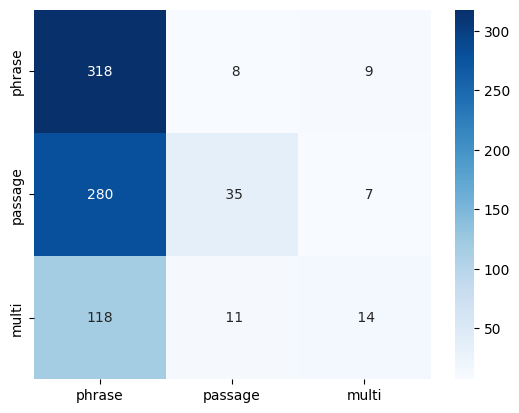

In [30]:
F1_scores_dict['dtc gini'] = F1_scores(y_test, y_pred_dtc_gini)
conf_matrix(y_test, y_pred_dtc_gini)

#### Decision Tree Classifier - entropy

In [31]:
dtc_entropy = DecisionTreeClassifier(criterion = "entropy", random_state = 123, max_depth = 5, min_samples_leaf = 6)
dtc_entropy.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=6,
                       random_state=123)

In [32]:
y_pred_dtc_entropy = prediction(X_test, dtc_entropy)

F1: [60.86124402 17.69436997 26.37362637] 
F1 weighted: 37.321915561509186


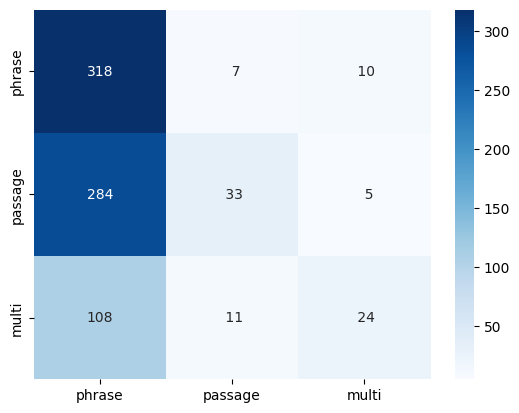

In [33]:
F1_scores_dict['dtc entropy'] = F1_scores(y_test, y_pred_dtc_entropy)
conf_matrix(y_test, y_pred_dtc_entropy)

#### SVM - linear kernel

In [34]:
svm_linear = svm.SVC(kernel='linear', C=1, decision_function_shape='ovo')
svm_linear.fit(X_train, y_train)

SVC(C=1, decision_function_shape='ovo', kernel='linear')

In [35]:
y_pred_svm_linear = prediction(X_test, svm_linear)

F1: [65.29562982 61.44200627 30.43478261] 
F1 weighted: 57.513169901961845


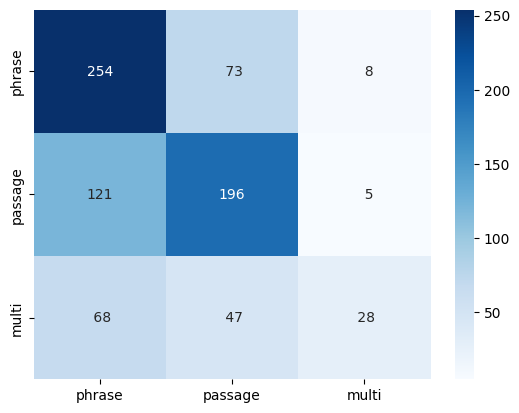

In [36]:
F1_scores_dict['svm linear'] = F1_scores(y_test, y_pred_svm_linear)
conf_matrix(y_test, y_pred_svm_linear)

#### SVM - rbf kernel

In [37]:
svm_rbf = svm.SVC(kernel='rbf', gamma=1, C=1, decision_function_shape='ovo')
svm_rbf.fit(X_train, y_train)

SVC(C=1, decision_function_shape='ovo', gamma=1)

In [38]:
y_pred_svm_rbf = prediction(X_test, svm_rbf)

F1: [64.87148103 58.88       13.92405063] 
F1 weighted: 53.35305673117146


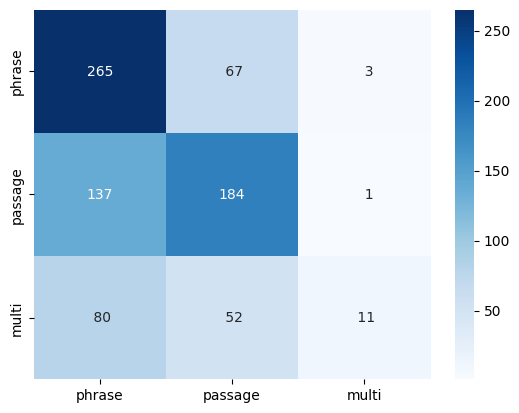

In [39]:
F1_scores_dict['svm rbf'] = F1_scores(y_test, y_pred_svm_rbf)
conf_matrix(y_test, y_pred_svm_rbf)

#### Naive Bayes

In [40]:
nb_multinomial = MultinomialNB()
nb_multinomial.fit(X_train, y_train)

MultinomialNB()

In [41]:
y_pred_nb_multinomial = prediction(X_test, nb_multinomial)

F1: [63.27272727 56.91573927  4.10958904] 
F1 weighted: 50.138628642194305


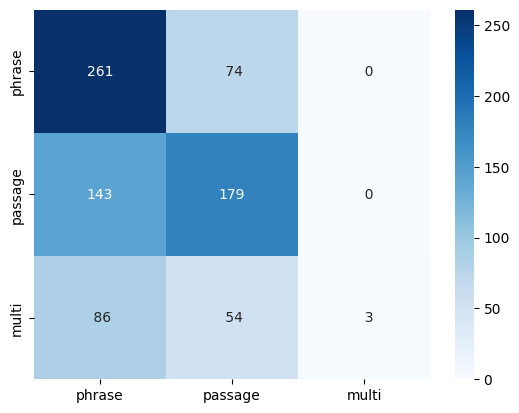

In [42]:
F1_scores_dict['nb multinomial'] = F1_scores(y_test, y_pred_nb_multinomial)
conf_matrix(y_test, y_pred_nb_multinomial)

#### Random Forest

In [61]:
rf_entropy = RandomForestClassifier(n_estimators = 400, criterion = 'entropy', random_state = 42)
rf_entropy.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=400, random_state=42)

In [62]:
y_pred_rf_entropy = prediction(X_test, rf_entropy)

F1: [64.92434663 61.51645207 22.98850575] 
F1 weighted: 56.05663751354837


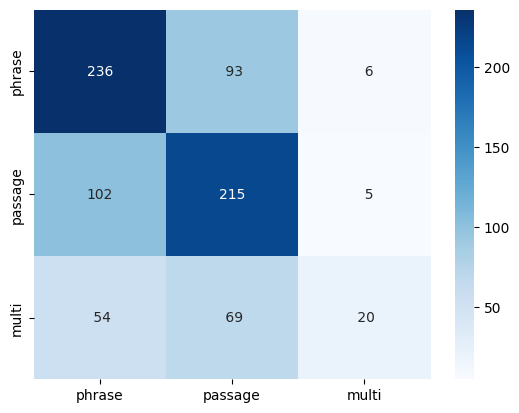

In [63]:
F1_scores_dict['rf entropy'] = F1_scores(y_test, y_pred_rf_entropy)
conf_matrix(y_test, y_pred_rf_entropy)

### Final F1 score

In [57]:
F1_scores_dict

{'dtc gini': 35.72656688361056,
 'dtc entropy': 37.321915561509186,
 'svm linear': 57.513169901961845,
 'svm rbf': 53.35305673117146,
 'nb multinomial': 50.138628642194305,
 'rf entropy': 56.05663751354837}